# Part2 BlobDetector
Author: Victor Badenas Crespo

## Purpose
Case study of the different effects of different corner detectors.

## Methodology
Modifying the example in [the scikit-image corner detection example](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py), the [corner detectors in the scikit image package](https://scikit-image.org/docs/stable/api/skimage.feature.html) are tested. 

Images from the [general purpose images of scikit-image](https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html) will be used to evaluate and explain the advantages and disadvantages of those corner detectors.

***
## Setup

### Library import
We import all the required Python libraries

In [1]:
import skimage
import numpy as np
import ipywidgets as widgets
import pandas as pd

from skimage import data, color, io
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
from pprint import pprint
from math import sqrt
from ipywidgets import interact, interactive, fixed, interact_manual

### Local library import and functions
We import all the required local libraries and user defined functions and utilities

In [2]:
def plotImages(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, image) in enumerate(images.items()):
        cmap = plt.cm.gray if image.ndim == 2 else None
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            ax[imageIdx].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[1]][imageIdx%grid[1]].set_title(title)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].axis('off')
    return f, ax

***
## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
# skimage data image list
images = {
    'astronaut': None,
    'binary_blobs': None,
    'brick': None,
    'colorwheel': None,
    'camera': None,
    'cat': None,
    'checkerboard': None,
    'clock': None,
    'coffee': None,
    'coins': None,
    'eagle': None,
    'grass': None,
    'gravel': None,
    'horse': None,
    'hubble_deep_field': None,
    'page': None,
    'text': None,
    'rocket': None
}


In [4]:
# corner extraction method's functions
methods = {
    "blob_dog": blob_dog, 
    "blob_log": blob_log, 
    "blob_doh": blob_doh
}

***
## Data import
We retrieve all the required data for the analysis.

In [5]:
# load all data images
for imageName in images:
    images[imageName] = getattr(data, imageName)()

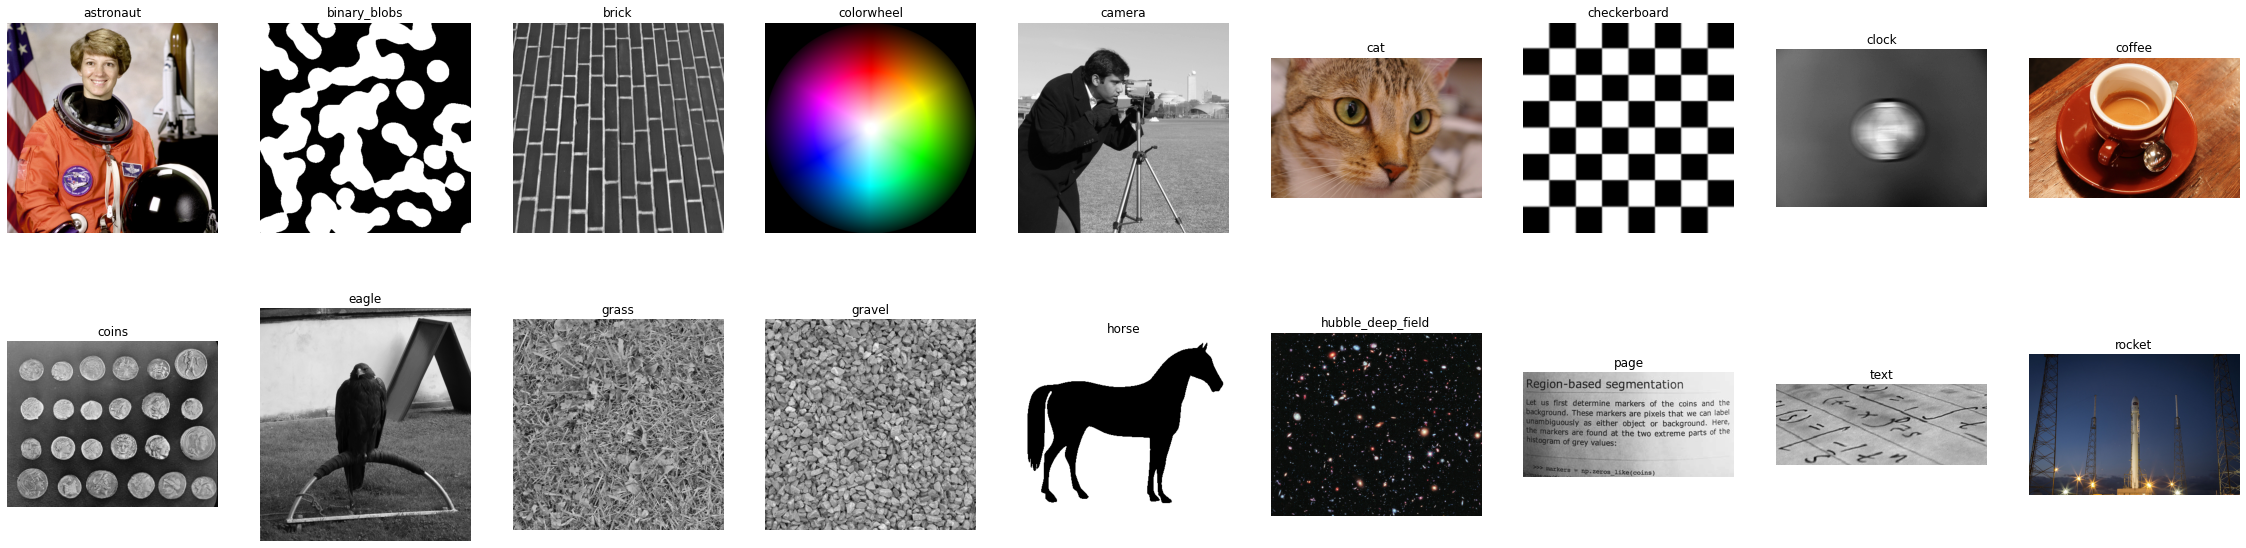

In [6]:
# plot all data images loaded in the previous cell
plotImages(images, grid=(2, int(len(images)/2)), figsize=(40, 10))
plt.show()

***
## Data processing

In [7]:
@interact(imageName=list(images.keys()))
def blob_detection(imageName='exampleImage'):
    image = images[imageName]
    image_gray = image if image.ndim <= 2 else rgb2gray(image)

    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    cmap = 'gray' if image.ndim == 2 else None

    for idx, (blobs, color, title) in enumerate(zip(blobs_list, colors, titles)):
        ax[idx].set_title(title)
        ax[idx].imshow(image, cmap=cmap)
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='imageName', options=('astronaut', 'binary_blobs', 'brick', 'colorw…

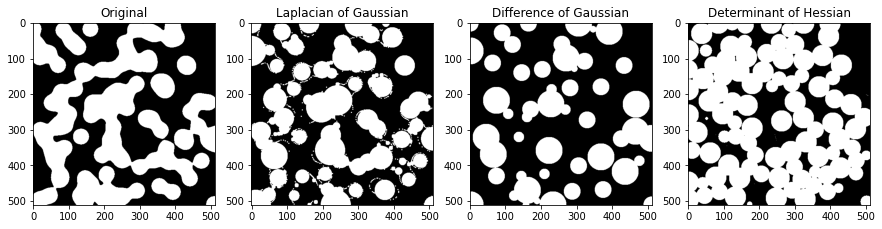

--------------------------------------------------------------------------------
                       predicted_blob  predicted_no_blob
Laplacian of Gaussian                                   
blob                           110556               7972
no_blob                         20516             123100
--------------------------------------------------------------------------------
                        predicted_blob  predicted_no_blob
Difference of Gaussian                                   
blob                             90413               7673
no_blob                          40659             123399
--------------------------------------------------------------------------------
                        predicted_blob  predicted_no_blob
Determinant of Hessian                                   
blob                             98117              77934
no_blob                          32955              53138
-----------------------------------------------------------------

In [22]:
imageName='binary_blobs'
image = images[imageName]
image_gray = image if image.ndim <= 2 else rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']

shape = image_gray.shape
generated_images = []
confusion_matrixes = []

for blobs, title in zip(blobs_list, titles):
    generated_images.append(np.zeros(shape, dtype=np.uint8))
    for blob in blobs:
        y, x, r = blob
        rr, cc = skimage.draw.disk((x, y), r, shape=shape)
        generated_images[-1][cc, rr] = 1

    tp = np.sum((generated_images[-1] > 0) * (image_gray > 0))
    fp = np.sum((generated_images[-1] > 0) * (image_gray == 0))
    tn = np.sum((generated_images[-1] == 0) * (image_gray == 0))
    fn = np.sum((generated_images[-1] == 0) * (image_gray > 0))
    df = pd.DataFrame([[tp, fp], [fn, tn]], columns=['predicted_blob', 'predicted_no_blob'], index=['blob', 'no_blob'])
    df.index.name = title
    confusion_matrixes.append(df)

f, ax = plt.subplots(1, 4, figsize=(15, 9), sharex=True)
ax[0].set_title('Original')
ax[0].imshow(image_gray, cmap='gray')
for idx in range(len(generated_images)):
    image, title = generated_images[idx], titles[idx]
    ax[idx+1].set_title(title)
    ax[idx+1].imshow(image, cmap='gray')
plt.show()

for df in confusion_matrixes:
    print('-'*80)
    print(df)
print('-'*80)    

***

## Discussion


### Laplacian of Gaussian (LoG)

From [skimage-docs](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html): This is the most accurate and slowest approach. It computes the Laplacian of Gaussian images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas in this cube. Detecting larger blobs is especially slower because of larger kernel sizes during convolution. Only bright blobs on dark backgrounds are detected.

### Difference of Gaussian (DoG)

From [skimage-docs](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html): This is a faster approximation of LoG approach. In this case the image is blurred with increasing standard deviations and the difference between two successively blurred images are stacked up in a cube. This method suffers from the same disadvantage as LoG approach for detecting larger blobs. Blobs are again assumed to be bright on dark.

### Determinant of Hessian (DoH)

From [skimage-docs](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html): This is the fastest approach. It detects blobs by finding maximas in the matrix of the Determinant of Hessian of the image. The detection speed is independent of the size of blobs as internally the implementation uses box filters instead of convolutions. Bright on dark as well as dark on bright blobs are detected. The downside is that small blobs (<3px) are not detected accurately.

Images selected for comparison:

- binary_blobs: this image contains the best case scenario for this algorithms as they are mostly white blobs on a black background. In this image the LoG (as was explained in the skimage-docs) is the most accurate, as most of the black region is not detected as a blob (false positive) and almost none of the white region is left undetected (low false negative).

***
## References
We report here relevant references:

1. The scikit-image corner detection example, https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py
2. Corner detectors in the scikit image package, https://scikit-image.org/docs/stable/api/skimage.feature.html
3. General purpose images of scikit-image, https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html
4. Viswanathan, Deepak. “Features from Accelerated Segment Test ( FAST ).” (2011).
5. Derpanis, K. G. (2004). The harris corner detector. York University, 2.